## 2.c Configure Flask Application

**GitHub Link:** [2.c Configure Flask Application](https://github.com/khhaledahmaad/attendance_monitoring_via_sms/blob/main/nbs/02c_configure_flask_application.ipynb)

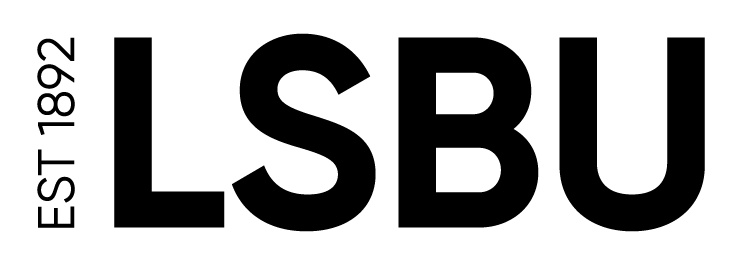

**Student Name:** Khaled Ahmed

**Student ID:** 3821656

**Project Title:** Attendance Monitoring via SMS   

**Course:** BEng Hons Computer Engineering

**Project Supervisor:** Dr Oswaldo Cadenas

## Introduction
This notebook shows how to configure the flask application, implementing the `Attendance monitoring via SMS` project. 

## Objectives
-  Import python all libraries and packages
-  Set up the paths to the project directories
-  Configure a flask application
-  Configure falsk-mailing
-  Configure flask-login and seesion management 
-  Define endpoints for flask application

## Configuartion

Make sure you have the required environments and packages configured, as mentioned in the `01a_set_up_the_environments
` notebook.

## Import Libraries

In [ ]:
import os
import re
import pathlib
import secrets
import pandas as pd
from typing import Dict, Optional
from flask import Flask, request, render_template, redirect, url_for
from flask_login import LoginManager, UserMixin, login_user, logout_user, login_required, current_user
from bs4 import BeautifulSoup
import altair as alt
from flask_mail import Mail, Message
from dotenv import load_dotenv
from datetime import date, datetime
from twilio.rest import Client

## Folder Structure
```python
|-- attendance_monioring_via_sms
|   |-- .twilio
|   |-- datasets
|      |-- *.csv
|   |-- docs
|      |-- *.md
|      |-- *.pdf
|   |-- env_vars
|      |-- .env.txt
|   |-- images
|      |-- *.png
|   |-- nbs
|      |-- *.ipynb 
|   |-- static
|      |- *.css
|      |- *.js
|   |-- templates
|      |- *.html
|   |-- app.py
|   |-- conda_env_twilio.yml
|   |-- requirements.txt

```

## Set Paths

In [ ]:
# Set paths
base_dir = pathlib.Path().absolute().parent

# Path to all data directories
data = pathlib.Path(base_dir/'datasets')

# Path to credentials data
credentials = data/'credentials'

# Path to raw data
raw = data/'raw'

# Path to processed data
processed = data/'processed'

# Path to environment variables
env_vars = pathlib.Path(base_dir/'env_vars')

## Load Environment Vaiables
All the sensitive user information are stored in a `.env.txt` file, which is loaded, using `dotenv`.

In [ ]:
# Load dotenv file
load_dotenv(env_vars/'.env.txt')

## Configure Flask App
The flask app has a flask-mail app to send emails, which is configured with an `smtp` based mail testing software/website called, `Mailtrap`. It creats dummy emails, sender and receiver rather than acutally sending the emails but with the same conventions that apply to the real emails.

The flask_login app tracks the login of the users to the application and used for session management and provide the endpoints from unauthorised access by an adversary.

In [ ]:
# Flask app
app = Flask(__name__)
# Configure a secret-key for the flask app
app.config["SECRET_KEY"] = secrets.token_hex(24)

# Configure flask mail app
app.config['MAIL_SERVER'] = 'smtp.mailtrap.io'
app.config['MAIL_PORT'] = 2525
app.config['MAIL_USERNAME'] = os.environ.get('MAIL_USERNAME')
app.config['MAIL_PASSWORD'] = os.environ.get('MAIL_PASSWORD')
app.config['MAIL_USE_TLS'] = True
app.config['MAIL_USE_SSL'] = False

# Create login_manager app
login_manager = LoginManager(app)
# Create mail app
mail = Mail(app)

# Create twilio client object
account_sid = os.environ.get("TWILIO_ACCOUNT_SID")
auth_token = os.environ.get("TWILIO_AUTH_TOKEN")
client = Client(account_sid, auth_token)

# Define a User class to store all the users from the .csv input files
users: Dict[str, "User"] = {}

class User(UserMixin):
    def __init__(self, id: str, username: str, email: str, password: str):
        self.id = id
        self.username = username
        self.email = email
        self.password = password

    @staticmethod
    def get(user_id: str) -> Optional["User"]:
        return users.get(user_id)

    def __str__(self) -> str:
        return f"<Id: {self.id}, Username: {self.username}, Email: {self.email}>"

    def __repr__(self) -> str:
        return self.__str__()

data = pd.read_csv(credentials/'login_credentials.csv')
for index in data.index:
    users[str(index)] = User(
        id=index,
        username=data.loc[index, "first_name"],
        email=data.loc[index, "email"],
        password=data.loc[index, "password"],
    )

###
"""
All the endpoints for the application goes here
"""
###

if __name__ == '__main__':
    app.run(debug=True)

## Endpoint for Creating a New Timetable

In [ ]:
# Endpoint for creating new timetable
@app.route('/create_timetable', methods=['GET', 'POST'])
@login_required
def create_timetable():  
    message = None
    df_admins = pd.read_csv(credentials/'admins.csv')

    years =  [str(date.today().year-1)+'-'+str(date.today().year)[2:], str(date.today().year)+'-'+str(date.today().year+1)[2:]]
    year_dict = {str(date.today().year-1)+'-'+str(date.today().year)[2:]: [date.today().year-1, date.today().year], str(date.today().year)+'-'+str(date.today().year+1)[2:]: [date.today().year, date.today().year+1]}

    if request.method == 'POST':
        year = request.form['year']
        year_1 = year_dict[year][0]
        year_2 = year_dict[year][1]

        total_academcic_week = int(request.form['total_weeks'])
        sem1_start = request.form['sem1_start']
        sem2_start = request.form['sem2_start']
        number_of_holiday_week1 = int(request.form['holiday_week1'])
        number_of_holiday_week2 = int(request.form['holiday_week2'])
        sem1_holiday_start = request.form['sem1_holiday_start']
        sem2_holiday_start = request.form['sem2_holiday_start']

        m = re.fullmatch('\d{4,4}-\d{2,2}-\d{2,2}', sem1_start)
        n = m = re.fullmatch('\d{4,4}-\d{2,2}-\d{2,2}', sem2_start)
        m_ = re.fullmatch('\d{4,4}-\d{2,2}-\d{2,2}', sem1_holiday_start)
        n_ = re.fullmatch('\d{4,4}-\d{2,2}-\d{2,2}', sem2_holiday_start)

        if sem1_start == '':
            message = message = 'Semester 1 Start Date is required!'
            return render_template('create_timetable.html', message=message, years=years)
        if sem1_holiday_start == '':
            message = message = 'Semester 2 Holiday Start Date is required!'
            return render_template('create_timetable.html', message=message, years=years)
        elif sem2_start == '':
            message = message = 'Semester 2 Start Date is required!'
            return render_template('create_timetable.html', message=message, years=years)
        elif sem2_holiday_start == '':
            message = message = 'Semester 2 Holiday Start Date is required!'
            return render_template('create_timetable.html', message=message, years=years)
        elif m == None:
            message = message = 'Semester 1 Start Date must be in \'YYYY-MM-DD\' format!'
            return render_template('create_timetable.html', message=message, years=years)
        elif m_ == None:
            message = message = 'Semester 1 Holiday Start Date must be in \'YYYY-MM-DD\' format!'
            return render_template('create_timetable.html', message=message, years=years)
        elif n == None:
            message = message = 'Semester 2 Start Date must be in \'YYYY-MM-DD\' format!'
            return render_template('create_timetable.html', message=message, years=years)
        elif n_ == None:
            message = message = 'Semester 2 Holiday Start Date must be in \'YYYY-MM-DD\' format!'
            return render_template('create_timetable.html', message=message, years=years)
        else:
            m_year = int(sem1_start[:4])
            m_month = int(sem1_start[5:7])
            m_year_ = int(sem1_holiday_start[:4])
            m_month_ = int(sem1_holiday_start[5:7])
            n_year = int(sem2_start[:4])
            n_month = int(sem2_start[5:7])
            n_year_ = int(sem2_holiday_start[:4])
            n_month_ = int(sem2_holiday_start[5:7])
            if m_year != year_1 or m_month != 9:
                message = message = f"Semester 1 Start Date must be in 'September' {year_1}!"
                return render_template('create_timetable.html', message=message, years=years)
            elif m_year_ != year_1 or m_month_ != 12:
                message = message = f"Semester 1 Holiday Start Date must be in 'December' {year_1}!"
                return render_template('create_timetable.html', message=message, years=years)
            if n_year != year_2 or n_month != 1:
                message = message = f"Semester 2 Start Date must be in 'January' {year_2}!"
                return render_template('create_timetable.html', message=message, years=years)
            elif n_year_ != year_2 or n_month_ != 4:
                message = message = f"Semester 2 Holiday Start Date must be in 'April' {year_2}!"
                return render_template('create_timetable.html', message=message, years=years)
            else:
                df_date = pd.DataFrame(pd.period_range(start=date(year_1, 9, 1), end=date(year_2, 6, 30), freq='W'), columns=['date_range'])
                df_date['month'] = df_date.date_range.dt.start_time.dt.month

                df1 = df_date.loc[df_date[df_date.date_range.dt.start_time.dt.date.astype(str) == sem1_start].index.values[0]:, ['date_range']].reset_index(drop=True)
                df2 = df_date.loc[df_date[df_date.date_range.dt.start_time.dt.date.astype(str) == sem2_start].index.values[0]:, ['date_range']].reset_index(drop=True)

                last_academic_week1 = df1[df1.date_range.dt.start_time.dt.date.astype(str) == sem1_holiday_start].index.values[0]
                last_academic_week2 = df2[df2.date_range.dt.start_time.dt.date.astype(str) == sem2_holiday_start].index.values[0]
                
                df1 = pd.concat([df1.loc[:last_academic_week1-1], df1.loc[last_academic_week1+number_of_holiday_week1:]]).reset_index(drop=True).loc[:total_academcic_week-1]
                df2 = pd.concat([df2.loc[:last_academic_week2-1], df2.loc[last_academic_week2+number_of_holiday_week2:]]).reset_index(drop=True).loc[:total_academcic_week-1]

                df1['academic_semester'] = 1
                df1['academic_week'] = df1.index+1
                df1['calendar_week'] = df1.date_range.dt.start_time.dt.week
                df1['week_start'] = df1.date_range.dt.start_time.dt.date
                df1['week_end'] = df1.date_range.dt.end_time.dt.date

                df1 = df1[['academic_semester', 'academic_week', 'calendar_week', 'date_range', 'week_start', 'week_end']]
                
                df2['academic_semester'] = 2
                df2['academic_week'] = df2.index+1
                df2['calendar_week'] = df2.date_range.dt.start_time.dt.week
                df2['week_start'] = df2.date_range.dt.start_time.dt.date
                df2['week_end'] = df2.date_range.dt.end_time.dt.date

                df2 = df2[['academic_semester', 'academic_week', 'calendar_week', 'date_range', 'week_start', 'week_end']]

                df = pd.concat([df1, df2], ignore_index=True)
                try:
                    test = df_admins.loc[df_admins.email==current_user.email, 'admin_status'].values[0]=='Yes'
                except:
                    message = 'This Account does not have the admin rights to create a new timetable. Please contact the system admin.'
                    return render_template('create_timetable.html', message=message, years=years)
                if test:
                    df.to_csv(credentials/f'timetable.csv', index=False)
                    message = 'Thanks for creating a new timetable! Please check the timetable on the Check Timetable page.'
                    return render_template('create_timetable.html', message=message, years=years)
                else:
                    message = 'This Account does not have the admin rights to create a new timetable. Please contact the system admin.'
                    return render_template('create_timetable.html', message=message, years=years)
    return render_template('create_timetable.html', message=message, years=years)

## Endpoint for Creating Attendance

In [ ]:
# Endpoint for creating attendance
@app.route('/create_attendance', methods=['GET', 'POST'])
@login_required
def create_attendance():  
    message = None
    df_students = pd.read_csv(credentials/'students.csv')
    df_courses = pd.read_csv(credentials/'courses.csv')
    df_timetable = pd.read_csv(credentials/'timetable.csv', parse_dates=['week_start', 'week_end'], infer_datetime_format=True)
    courses = df_courses.course_name.dropna().unique()
    weeks = list(df_timetable.academic_week.dropna().unique())

    days_dict = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
    if request.method == 'POST':
        course_name =request.form['comp_select']
        course_code = df_courses.loc[df_courses.course_name == course_name, 'course_code'].squeeze()
        semester = int(request.form['comp_select1'])
        academic_week = int(request.form['comp_select2'])

        file_name = f'{course_code}_semester_{semester}_week_{academic_week}_attendance.csv'

        if (processed/'attendance'/file_name).exists():
            message = f"Attendance for '{course_name}' for 'semester {semester}', 'week {academic_week}' already exists! Please go to the 'Check Attendance' page to check the attendance."
            return render_template('create_attendance.html', message=message, courses=courses, weeks=weeks)

        else:
            teaching_day = df_courses.loc[df_courses.course_name == course_name, 'teaching_day'].squeeze()
            day_num_in_week = days_dict[teaching_day]

            week_start = df_timetable.loc[(df_timetable.academic_semester==semester) & (df_timetable.academic_week==academic_week), 'week_start'] 
            year = (week_start + pd.DateOffset(days=day_num_in_week)).dt.year.squeeze()
            month = (week_start + pd.DateOffset(days=day_num_in_week)).dt.month.squeeze()
            month_name = (week_start + pd.DateOffset(days=day_num_in_week)).dt.month_name().squeeze()
            week = (week_start + pd.DateOffset(days=day_num_in_week)).dt.week.squeeze()
            day = (week_start + pd.DateOffset(days=day_num_in_week)).dt.day.squeeze()
            day_name = (week_start + pd.DateOffset(days=day_num_in_week)).dt.day_name().squeeze()
            date = (week_start + pd.DateOffset(days=day_num_in_week)).dt.date.squeeze()
            start_hour = int(df_courses.loc[df_courses.course_name == course_name, 'start_time'].apply(lambda x: str(x)[:2]).squeeze())
            end_hour = int(df_courses.loc[df_courses.course_name == course_name, 'end_time'].apply(lambda x: str(x)[:2]).squeeze())
            
            # Retrieve sms using the client object
            messages = client.messages.list(
                date_sent_after=datetime(year, month, day, start_hour, 0, 0),
                date_sent_before=datetime(year, month, day, end_hour, 0, 0)
            )
            if len(messages) == 0:
                message = 'No attendance received for that week!'
                return render_template('create_attendance.html', message=message, courses=courses, weeks=weeks)
            else:
                # Append the retrieved sms's to a dataframe
                d = []
                for message in messages:
                    d.append((message.from_, message.body, message.status, message.date_sent))

                df = pd.DataFrame(d, columns=['from' ,'message' ,'status' ,'date_sent'])
                try:
                    df['student_id'] = df.message.str.split(' ', expand=True, n=1)[0]
                except:
                    df['student_id'] = None
                try:
                    df['course_code'] = df.message.str.split(' ', expand=True, n=1)[1]
                except:
                    df['course_code'] = None
                
                # function to extract student name
                def student_name(df):
                    first_name = df_students.loc[df_students.student_id.astype(str) == df.student_id, 'first_name'].squeeze()
                    last_name = df_students.loc[df_students.student_id.astype(str) == df.student_id, 'last_name'].squeeze()
                    df['student_name'] = first_name+ ' ' + last_name
                    return df

                df = df.loc[df.status=='received'].apply(student_name, axis='columns')

                df_attendance = df.loc[(df.student_id.isin(df_students.student_id.astype(str))) & (df.course_code==str(course_code))]
                df_attendance = df_attendance[['from', 'student_id', 'student_name', 'message', 'date_sent']]
                df_invalid_attendance = df.loc[~(df.student_id.isin(df_students.student_id.astype(str))) | (df.course_code!=str(course_code))]
                
                file_name_raw = f'{course_code}_semester_{semester}_week_{academic_week}_raw.csv'
                file_name_spam = f'{course_code}_semester_{semester}_week_{academic_week}_spammed.csv'

                df.to_csv(raw/file_name_raw, index=False)
                df_attendance.to_csv(processed/'attendance'/file_name, index=False)
                df_invalid_attendance.to_csv(processed/'spam'/file_name_spam, index=False)

                df_weekly = pd.read_csv(processed/'weekly_attendance.csv')

                df_weekly = df_weekly.append({
                    'course_name': course_name, 'course_code': course_code, 'date': date, 'year': year, 'month': month_name,
                    'day': day_name, 'week': week, 'academic_semester': semester, 'academic_week': academic_week, 'total_attendees': len(df_attendance)
                }, ignore_index=True)
                df_weekly.to_csv(processed/'weekly_attendance.csv', index=False)
                
                # Acknowledgement message to the students
                for student in df_attendance.student_id:
                    student_name = df_students.loc[df_students.student_id.astype(str).isin([student]), 'first_name'].squeeze()
                    student_phone_no = df_attendance.loc[df_attendance.student_id==student, 'from'].squeeze()

                    client.messages.create(
                    body = f"Hi {student_name}, congratulations! Your attendance for '{course_name}', 'semester {semester}', 'week {academic_week}' has been successfully registered.",
                    from_ = os.environ.get("TWILIO_PHONE_NUMBER"),
                    to=student_phone_no)
                
                # Email the attendance to the tutor
                tutor_name = df_courses.loc[df_courses.course_name == course_name, 'tutor'].str.split(' ', expand=True, n=1)[0].squeeze()
                tutor_email = df_courses.loc[df_courses.course_name == course_name, 'email'].squeeze()
                msg = Message(f'Attendance- {course_name}, semester {semester}, week {academic_week}',
                          sender="admin@attendance.lsbu.ac.uk", recipients=[tutor_email])
                msg.body = f"Hi {tutor_name},\n\nThe attendance for '{course_name}' for 'semester {semester}', 'week {academic_week}' has been created.\n\nPlease find the attendance attached!\n\nKind Regards,\nAttendance Team"
                with app.open_resource(f'datasets\\processed\\attendance\\{file_name}') as fp:  
                    msg.attach(f'datasets\\processed\\attendance\\{file_name}', "text/csv", fp.read()) 
                mail.send(msg)

                message = f"Attendance for '{course_name}' for 'semester {semester}', 'week {academic_week}' created successfully! Please go to the 'Check Attendance' page to check the attendance."
                return render_template('create_attendance.html', message=message, courses=courses, weeks=weeks)
    return render_template('create_attendance.html', courses=courses, weeks=weeks)

The other endpoints are discussed in the later notebooks.

### Summary
In this notebook it was demonstrated how to:
-  Import python all libraries and packages
-  Set up the paths to the project directories
-  Configure a flask application
-  Configure falsk-mailing
-  Configure flask-login and seesion management 
-  Define endpoints for flask application

<center><b>Author</b></center>

| Name | Date Created | Last Modified |
|------|--------------|---------------|
|Khaled Ahmed | 30/01/2023 | 30/01/2023|